In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from ffflows.models import BaseFlow
from ffflows.utils import set_trainable
from ffflows.utils import get_activation, spline_inn, get_flow4flow, get_conditional_data

from nflows.distributions import StandardNormal

from ffflows.data.conditional_plane import ScienceDataset

import yaml


device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [2]:
# Get training data

train_sim_data = torch.from_numpy(np.load("LHCO_data/train_sim_data.npy")).to(torch.float32)
val_sim_data = torch.from_numpy(np.load("LHCO_data/val_sim_data.npy")).to(torch.float32)
train_dat_data = torch.from_numpy(np.load("LHCO_data/train_dat_data.npy")).to(torch.float32)
val_dat_data = torch.from_numpy(np.load("LHCO_data/val_dat_data.npy")).to(torch.float32)

train_sim_cont = torch.from_numpy(np.load("LHCO_data/train_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
val_sim_cont = torch.from_numpy(np.load("LHCO_data/val_sim_cont.npy").reshape(-1, 1)).to(torch.float32)
train_dat_cont = torch.from_numpy(np.load("LHCO_data/train_dat_cont.npy").reshape(-1, 1)).to(torch.float32)
val_dat_cont = torch.from_numpy(np.load("LHCO_data/val_dat_cont.npy").reshape(-1, 1)).to(torch.float32)

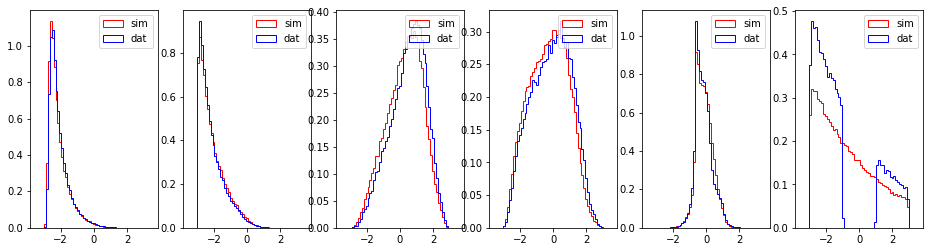

In [3]:
# Plot training data

bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 6, figsize = (16, 4))

for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    ax[i].legend()
    
# context
ax[5].hist(val_sim_cont.numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
ax[5].hist(val_dat_cont.numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
ax[5].legend()
    
plt.show()

# Set up directories to hold the transformed data


In [4]:
transformed_data = {}

# Double base flow

In [5]:
flow_dir = "/global/home/users/rrmastandrea/flows4flows/writeup2/science"

with open(f"{flow_dir}/science.yaml") as f:
    defaults_doublebase = yaml.safe_load(f)

base_flow_left_path = f"{flow_dir}/base_left/epoch_59.pt"
base_flow_right_path = f"{flow_dir}/base_right/epoch_59.pt"

In [6]:
# load in the flow

base_flow_left = BaseFlow(spline_inn(defaults_doublebase["general"]["data_dim"],
                                    nodes = defaults_doublebase["base_dist"]["left"]["nnodes"],
                                 num_blocks =   defaults_doublebase["base_dist"]["left"]["nblocks"],
                                    num_stack = defaults_doublebase["base_dist"]["left"]["nstack"],
                                    tail_bound=4.0,
                                    num_bins=defaults_doublebase["base_dist"]["left"]["nbins"],
                                    context_features=defaults_doublebase["general"]["ncond"]
                                    ),
                         StandardNormal([defaults_doublebase["general"]["data_dim"]])
                         )
    
base_flow_left.load_state_dict(torch.load(base_flow_left_path, map_location=device))


base_flow_right = BaseFlow(spline_inn(defaults_doublebase["general"]["data_dim"],
                                    nodes = defaults_doublebase["base_dist"]["right"]["nnodes"],
                                 num_blocks =   defaults_doublebase["base_dist"]["right"]["nblocks"],
                                    num_stack = defaults_doublebase["base_dist"]["right"]["nstack"],
                                    tail_bound=4.0,
                                    num_bins=defaults_doublebase["base_dist"]["right"]["nbins"],
                                    context_features=defaults_doublebase["general"]["ncond"]
                                    ),
                         StandardNormal([defaults_doublebase["general"]["data_dim"]])
                         )
    

base_flow_right.load_state_dict(torch.load(base_flow_right_path, map_location=device))
        
set_trainable(base_flow_left, False)        
set_trainable(base_flow_right, False)
            

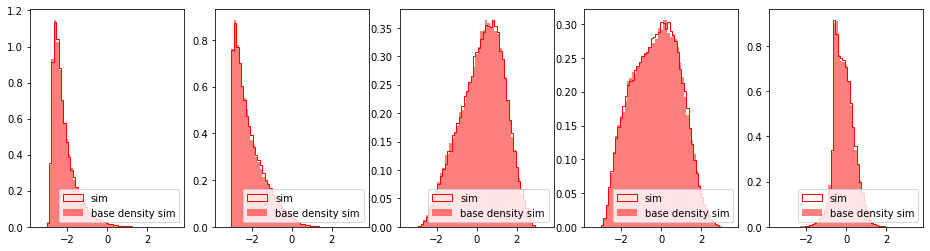

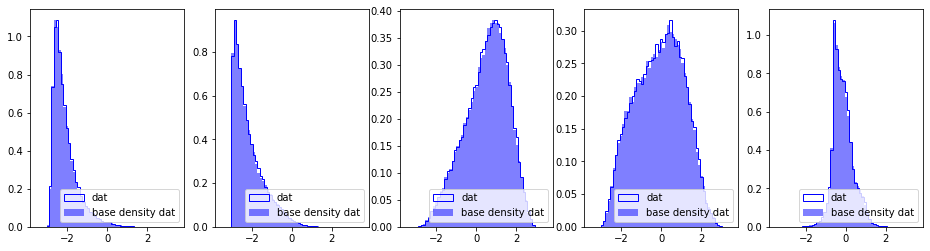

In [7]:
# check training
sim_dataset = ScienceDataset(val_sim_data, val_sim_cont)
dat_dataset = ScienceDataset(val_dat_data, val_dat_cont)

# sample from the sim_bd
n_transform = 55753

noise = torch.normal(0, 1, size=(n_transform, 5))
bd_sim_samples, _ = base_flow_left._transform.inverse(noise, sim_dataset.conditions[:n_transform])
bd_dat_samples, _ = base_flow_right._transform.inverse(noise, dat_dataset.conditions[:n_transform])


bins = np.linspace(-3.5, 3.5, 60)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(bd_sim_samples[:,i].numpy(), bins = bins, label = "base density sim", histtype = "bar", density = True, color = "red", alpha = 0.5)
    ax[i].legend(loc = "lower right")
    
plt.show()


fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    ax[i].hist(bd_dat_samples[:,i].numpy(), bins = bins, label = "base density dat", histtype = "bar", density = True, color = "blue", alpha = 0.5)
    ax[i].legend(loc = "lower right")
    
plt.show()

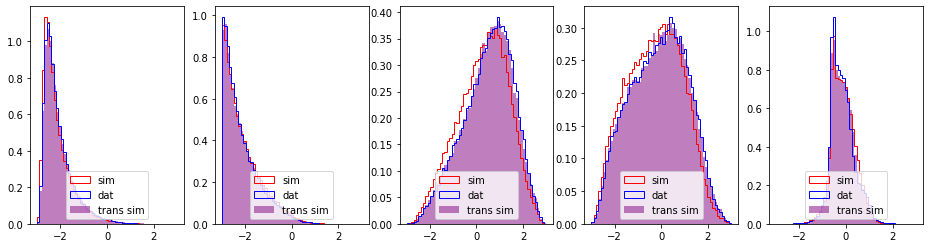

In [8]:
# transform


sim_to_noise, _ = base_flow_left._transform(sim_dataset.data[:n_transform], sim_dataset.conditions[:n_transform])
transformed_sim, _ = base_flow_right._transform.inverse(sim_to_noise, sim_dataset.conditions[:n_transform])


bins = np.linspace(-3, 3, 60)

fig, ax = plt.subplots(1, 5, figsize = (16, 4))
for i in range(5):
    ax[i].hist(val_sim_data[:,i].numpy(), bins = bins, label = "sim", histtype = "step", density = True, color = "red")
    ax[i].hist(val_dat_data[:,i].numpy(), bins = bins, label = "dat", histtype = "step", density = True, color = "blue")
    ax[i].hist(transformed_sim[:,i].numpy(), bins = bins, label = "trans sim", histtype = "bar", density = True, color = "purple", alpha = 0.5)
    ax[i].legend(loc = "lower center")
plt.show()

transformed_data["base_transfer"] = transformed_sim.numpy()


# Transfer flows

In [9]:
flow_dirs = {"f4f":"/global/home/users/rrmastandrea/flows4flows/writeup2/science",
            "inverse":"/global/home/users/rrmastandrea/flows4flows/writeup2/science_inv",
             "L1":"/global/home/users/rrmastandrea/flows4flows/writeup2/science_L1",
           #  "L1_identinit":"/global/home/users/rrmastandrea/flows4flows/writeup2/science_L1_identinit",
             "identinit":"/global/home/users/rrmastandrea/flows4flows/writeup2/science_identinit",
            }


loaded_flows = {}
for key in flow_dirs.keys():
    
    loc_flow_dir = flow_dirs[key]
    
    print(f"On key {key}...")
    
    yaml_key = loc_flow_dir.split("/")[-1]
    
    with open(f"{loc_flow_dir}/{yaml_key}.yaml") as f:
        loc_defaults = yaml.safe_load(f)

    # load in the flow
    loc_transfer_flow = get_flow4flow("discretebasecondition",
                               spline_inn(loc_defaults["general"]["data_dim"],
                                          nodes=loc_defaults["top_transformer"]["nnodes"],
                                          num_blocks=loc_defaults["top_transformer"]["nblocks"],
                                          num_stack=loc_defaults["top_transformer"]["nstack"],
                                          tail_bound=4.0,
                                          num_bins=loc_defaults["top_transformer"]["nbins"],
                                          context_features=loc_defaults["general"]["ncond"],
                                          flow_for_flow=True
                                          ),
                               base_flow_left)
    
    if key != "inverse":
        loc_transfer_flow_path = f"{loc_flow_dir}/f4f/epoch_63.pt"
    else:
        loc_transfer_flow_path = f"{loc_flow_dir}/f4f_inv/epoch_63.pt"
    
    loc_transfer_flow.load_state_dict(torch.load(loc_transfer_flow_path, map_location=device))
        
    set_trainable(loc_transfer_flow, False)
    
    loaded_flows[key] = loc_transfer_flow
            
 

On key f4f...
On key inverse...
On key L1...
On key identinit...


In [10]:
# transform
inverse = False


for key in flow_dirs.keys():

    loc_transformed_sim, _ = loaded_flows[key].transform(sim_dataset.data[:n_transform], sim_dataset.conditions[:n_transform], dat_dataset.conditions[:n_transform], inverse = inverse)
    transformed_data[key] = loc_transformed_sim.numpy()



/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib6

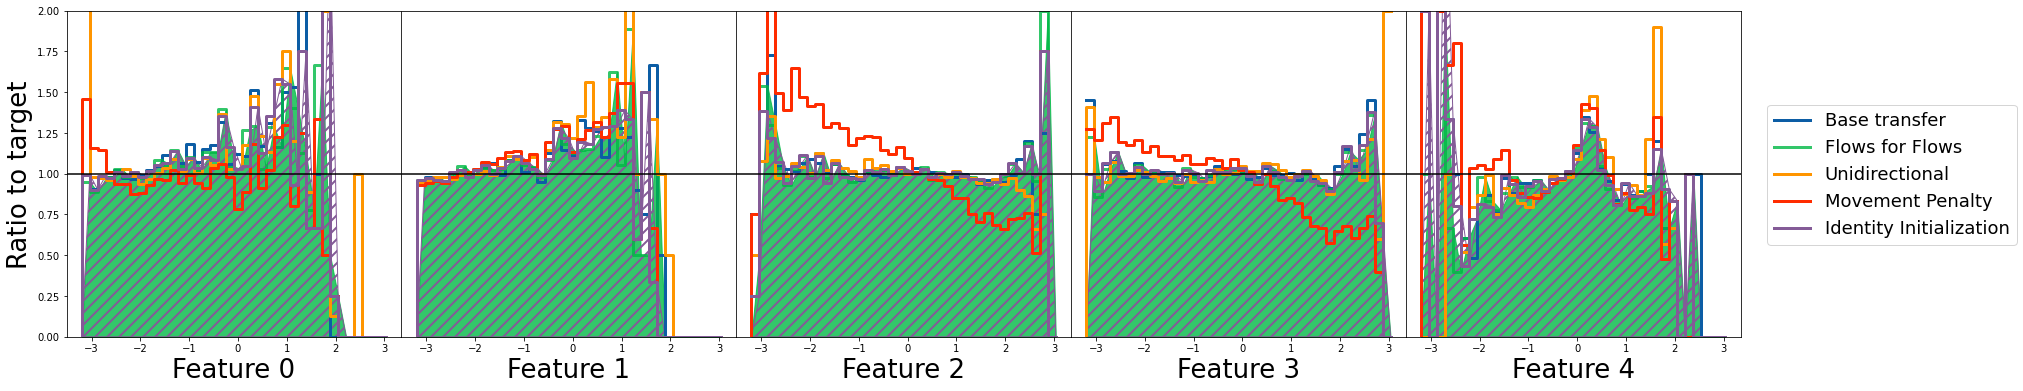

In [12]:

labels_dict = {"base_transfer":"Base transfer",
              "f4f":"Flows for Flows",
              "inverse":"Unidirectional",
              "L1":"Movement Penalty",
              "L1_identinit":"MP + II",
              "identinit":"Identity Initialization",
              }



style_dict = {"baseline":["step", "black", 1, "", 2],  # step, color, alpha, hash, linewidth
             "base_transfer":["step", "#0C5DA5", 1, "", 3],
             "f4f":["stepfilled", "#00B945", .8, "", 3],
             "inverse":["step", "#FF9500", 1, "", 3],
             "L1":["step", "#FF2C00", 1, "", 3],
             "identinit":["step", "#845B97", 1, "//", 3]}

import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 2  # previous pdf hatch linewidth



# get summary stats



bins = np.linspace(-3.2, 3.2, 40)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))

for i in range(5):
    
    # get target histogram
    values_target, _ = np.histogram(val_dat_data[:,i].numpy(), bins = bins, density = True)
    
    for key in transformed_data.keys():
        loc_values, _ = np.histogram(transformed_data[key][:,i], bins = bins, density = True)
        loc_ratio = np.nan_to_num(np.divide(loc_values, values_target))
        
        if i == 0:
            ax[i].step(bins[:-1], loc_ratio, label = labels_dict[key], color = style_dict[key][1],
                              alpha = style_dict[key][2], linewidth = 3)   
        else: 
            ax[i].step(bins[:-1], loc_ratio,color = style_dict[key][1],
                              alpha = style_dict[key][2], linewidth = 3)
        if key == "f4f":
            
            loc_ratio[loc_ratio < 0] = 0
            loc_ratio[loc_ratio > 10 ] = 0
            
            ax[i].fill_between(bins[:-1], loc_ratio, color = style_dict[key][1], alpha = style_dict[key][2])
        if key == "identinit":
            ax[i].fill_between(bins[:-1], loc_ratio, edgecolor = style_dict[key][1], alpha = style_dict[key][2], hatch="//",facecolor = "none")
            
            
    ax[i].set_xlabel(f"Feature {i}", fontsize = 26)
    ax[i].set_ylim(0, 2)
    ax[i].axhline(1, color = "black")
    #ax[i].set_aspect("equal")
    if i != 0:
        ax[i].set_yticks([])


plt.subplots_adjust(wspace=0, hspace=0)
        
fig.legend(fontsize = 18, loc = "center", bbox_to_anchor = (.97, .5))
ax[0].set_ylabel("Ratio to target", fontsize = 26)
plt.savefig(f"plots/science_feature_ratios", bbox_inches="tight")
plt.show()



# Distances traveled

In [ ]:
total_distances_traveled = {}
feature_distances_traveled = {i:{} for i in range(5)}

for key in transformed_data.keys():
    
    dels = sim_dataset.data[:n_transform].numpy() - transformed_data[key]
    
    for i in range(5):
        feature_distances_traveled[i][key] = np.abs(dels[:,i])

    total_distances_traveled[key] = np.sqrt(np.sum(dels**2, axis = 1))


In [ ]:
bins = np.linspace(0, .7, 60)
n_round = int(2)

fig = plt.figure(figsize = (8, 8))

for key in transformed_data.keys():
    
    label = labels_dict[key]

    loc_mean = np.mean(total_distances_traveled[key])
    loc_std = np.std(total_distances_traveled[key])

    str_mean = '{0:.{1}f}'.format(loc_mean, 2)
    std_std = '{0:.{1}f}'.format(loc_std, 2)
    
    
    stats = f" ($\mu$ = {str_mean}, $\sigma$ = {std_std})"
    
    plt.hist(total_distances_traveled[key], bins = bins, label = label+stats, density = True,
            histtype = style_dict[key][0], color = style_dict[key][1],
                          alpha = style_dict[key][2],  hatch = style_dict[key][3],linewidth = style_dict[key][4])
    
   
    print(f"{label} & {loc_mean} & {loc_std} \\\\")
    
    
plt.ylim(0, 10)  
    
plt.xlabel("Distance traveled", fontsize = 30)
plt.ylabel("Density", fontsize = 30)
plt.legend(fontsize = 15)
plt.savefig(f"plots/science_distances_traveled_total", bbox_inches="tight")

plt.show()



In [ ]:
bins = np.linspace(0, .4, 60)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
for i in range(5):
    
    ax[i].set_ylim(0, 20)
    
    for key in transformed_data.keys():
    
        ax[i].hist(feature_distances_traveled[i][key], bins = bins, label = labels_dict[key], 
                   histtype = style_dict[key][0], density = True,color = style_dict[key][1],
                          alpha = style_dict[key][2],  hatch = style_dict[key][3], linewidth = style_dict[key][4])
    ax[i].set_xlabel(f"Distance traveled in $f_{i}$", fontsize = 26)
    ax[i].set_ylim(0,15)
    
    if i != 0:
        ax[i].set_yticks([])


plt.subplots_adjust(wspace=0, hspace=0)
ax[0].legend(fontsize = 18)
ax[0].set_ylabel("Density", fontsize = 26)
plt.savefig(f"plots/science_distances_traveled_features", bbox_inches="tight")
plt.show()




In [ ]:
dpi = 800

feta_dir = "/global/home/users/rrmastandrea/FETA/"

# features plots

alpha = 0.5
n_plot = 10000
bins = 40
w = 2


import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1 #set the value globally


n_features = 6
    

"""fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 5))

for i in range(n_features):
    ax[i].hist(data_sim[:n_plot,i], bins = bins, density = True, label = "SIM", histtype = "step", color = sim_color, linewidth = w)
    ax[i].hist(data_dat[:n_plot,i], bins = bins, density = True, label = "DAT", histtype = "step", color = dat_color, linewidth = w)
    ax[i].hist(data_signal[:n_plot,i], bins = bins, density = True, label = "Signal", histtype = "step", color = "green", linewidth = w)

    ax[i].set_xlabel(feature_labels[i], fontsize = 30)
    ax[i].set_yticks([])
    
ax[0].set_ylabel("Normalized Density")  
ax[0].legend(fontsize = 20)  
plt.tight_layout()
fig.savefig("paper_plots/features_w_sig.png", dpi = dpi)
fig.show()

    """




plt.figure(figsize = (3, 3))

bins = np.linspace(2500, 4500, 40)

plt.hist(data_sim[:n_plot,5], bins = bins, density = True, label = "$X_R$", histtype = "step", color = sim_color, linewidth = w)
plt.hist(data_dat[:n_plot,5], bins = bins, density = True, label = "$X_T$", histtype = "step", color = dat_color, linewidth = w)
plt.axvline(2900, color = "black", linestyle = "dashed")
plt.axvline(3300, color = "black", linestyle = "dashed")
plt.axvline(3700, color = "black", linestyle = "dashed")
plt.axvline(4100, color = "black", linestyle = "dashed")

#plt.text(3100, .001, "Sideband", horizontalalignment='center', fontsize = 9)
#plt.text(3500, .001, "Signal region", horizontalalignment='center', fontsize = 9)
#plt.text(3900, .001, "Sideband", horizontalalignment='center', fontsize = 9)

plt.text(3100, .0009, "SB", horizontalalignment='center', fontsize = 20)
plt.text(3500, .0009, "SR", horizontalalignment='center', fontsize = 20)
plt.text(3900, .0009, "SB", horizontalalignment='center', fontsize = 20)


plt.xlabel("$M$", fontsize = f_0)
plt.xlim(2800, 4200)
plt.yticks([])
plt.xticks([2900, 3300, 3700, 4100])

plt.ylabel("Normalized Density", fontsize = f_1)  
#plt.legend(fontsize = 20)  
plt.tight_layout()
plt.savefig("paper_plots/M.png", dpi = dpi)
plt.show()


fig, ax = plt.subplots(1, 2, figsize = (6, 3))

bins = np.linspace(0, 1, 40)
ax[0].hist(data_sim[:n_plot,2], bins = bins, density = True, label = "$X_\mathrm{SIM}$", histtype = "step", color = sim_color, linewidth = w)
ax[0].hist(data_dat[:n_plot,2], bins = bins, density = True, label = "$X_\mathrm{DAT}$", histtype = "step", color = dat_color, linewidth = w)
ax[0].set_xlabel("Feature 1", fontsize = f_0)
ax[0].set_yticks([])

bins = np.linspace(0, 1000, 40)
ax[1].hist(data_sim[:n_plot,0], bins = bins, density = True, label = "$X_\mathrm{SIM}$", histtype = "step", color = sim_color, linewidth = w)
ax[1].hist(data_dat[:n_plot,0], bins = bins, density = True, label = "$X_\mathrm{DAT}$", histtype = "step", color = dat_color, linewidth = w)
ax[1].set_xlabel("Feature 2", fontsize = f_0)
ax[1].set_yticks([])

ax[0].set_ylabel("Normalized Density", fontsize = f_1)  
ax[1].legend(fontsize = f_0)  
plt.tight_layout()
fig.savefig("paper_plots/features_nips.png", dpi = dpi)
fig.show()

   

